# Python_Stochastic Volatility Models Simulation and Statistical Model
## Mean Reversion Models (Ornstein-Uhlenbeck Process, Heston Model) and Volatility Clustering (GJR-GARCH Model)

In [43]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [44]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import yfinance as yf
from scipy.stats import kstest, norm, t, laplace , cauchy

In [45]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")

Python version: 3.10.14
numpy version: 1.22.1
panda version: 2.0.3
seaborn version: 0.13.2
matplotlib version: 3.7.5
statsmodel version: 0.14.1
scipy version: 1.7.3


In [46]:
endDate = "2025-01-01"
startDate = "2020-01-01"

ticker ='AAPL'

# Download AAPL stock data
aapl = yf.download(ticker, start=startDate, end=endDate)

# Calculate daily log returns
aapl['Log Return'] = np.log(aapl['Adj Close'] / aapl['Adj Close'].shift(1))

# Calculate daily volatility (standard deviation of log returns) 
daily_volatility = aapl['Log Return'].std() 

# Calculate 21-day rolling (historical) volatility 
window = 21
aapl['21-Day Rolling Volatility'] = aapl['Log Return'].rolling(window=window).std()

# Calculate Annualize rolling volatility 
trading_days = 252 
#aapl['annualized_volatility'] = aapl['21-Day Rolling Volatility'] * np.sqrt(trading_days)
annualized_volatility = daily_volatility * np.sqrt(trading_days)

print(f"AAPL Stock daily Volatility: {daily_volatility:.2%}")
print(f"AAPL Stock Annualized Volatility: {annualized_volatility:.2%}")

aapl.tail()

[*********************100%%**********************]  1 of 1 completed

AAPL Stock daily Volatility: 2.00%
AAPL Stock Annualized Volatility: 31.69%


,Open,High,Low,Close,Adj Close,Volume,Log Return,21-Day Rolling Volatility
Date,,,,,,,,
2024-12-18,252.160004,254.279999,247.740005,248.050003,248.050003,56774100,-0.021655,0.008243
2024-12-19,247.500000,252.000000,247.089996,249.789993,249.789993,60882300,0.006990,0.008240
2024-12-20,248.039993,255.000000,245.690002,254.490005,254.490005,147495300,0.018641,0.008807
2024-12-23,254.770004,255.649994,253.449997,255.270004,255.270004,40858800,0.003060,0.008670
2024-12-24,255.490005,258.209991,255.289993,258.200012,258.200012,23234700,0.011413,0.008772


In [47]:
from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests

result = adfuller(aapl['Log Return'].dropna(),regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -11.294341
p-value: 0.000000
Critical Values:
	1%: -4.380
	5%: -3.837
	10%: -3.556
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [48]:
from scipy.stats import kstest, norm, t, laplace, cauchy

# Dictionary to hold the distributions and their corresponding fit methods
distributions = {
    'Normal': norm,
    'T-distribution': t,
    'Laplace': laplace,
    'Cauchy': cauchy
}

# Significance level
alpha = 0.05

# Function to perform KS test for each column in the DataFrame
def ks_test_dataframe(col, distributions, alpha=0.05):
    results = {}
    for dist_name, dist in distributions.items():
        # Fit the distribution to the sample and get the parameters
        params = dist.fit(col)
        # Perform the KS test using the fitted parameters
        ks_stat, p_value = kstest(col, dist.cdf, args=params)
        # Determine if we reject or fail to reject the null hypothesis
        if p_value > alpha:
            results[dist_name] = f'Fail to reject H0 (p-value: {p_value:.4f}), Parameters: {params}'
        else:
            results[dist_name] = f'Reject H0 (p-value: {p_value:.4f}), Parameters: {params}'
    return results

# Perform the KS test for each column in the DataFrame
results = ks_test_dataframe(aapl['Log Return'].dropna(), distributions, alpha)

# Print the results
for dist, dist_results in results.items():
    print(f'Distribution: {dist} :\n {dist_results}')


Distribution: Normal :
 Reject H0 (p-value: 0.0000), Parameters: (0.0010104336313972529, 0.019954399968218604)
Distribution: T-distribution :
 Fail to reject H0 (p-value: 0.9759), Parameters: (3.5955070099046007, 0.0012840812195010125, 0.01367888391386553)
Distribution: Laplace :
 Fail to reject H0 (p-value: 0.6360), Parameters: (0.0012326557329269791, 0.014026671739838079)
Distribution: Cauchy :
 Reject H0 (p-value: 0.0005), Parameters: (0.0012192431535332075, 0.00941237085741402)


## Mean-Reverting Behavior: If the time series oscillates around the moving average and tends to return to it, this suggests mean-reverting behavior.

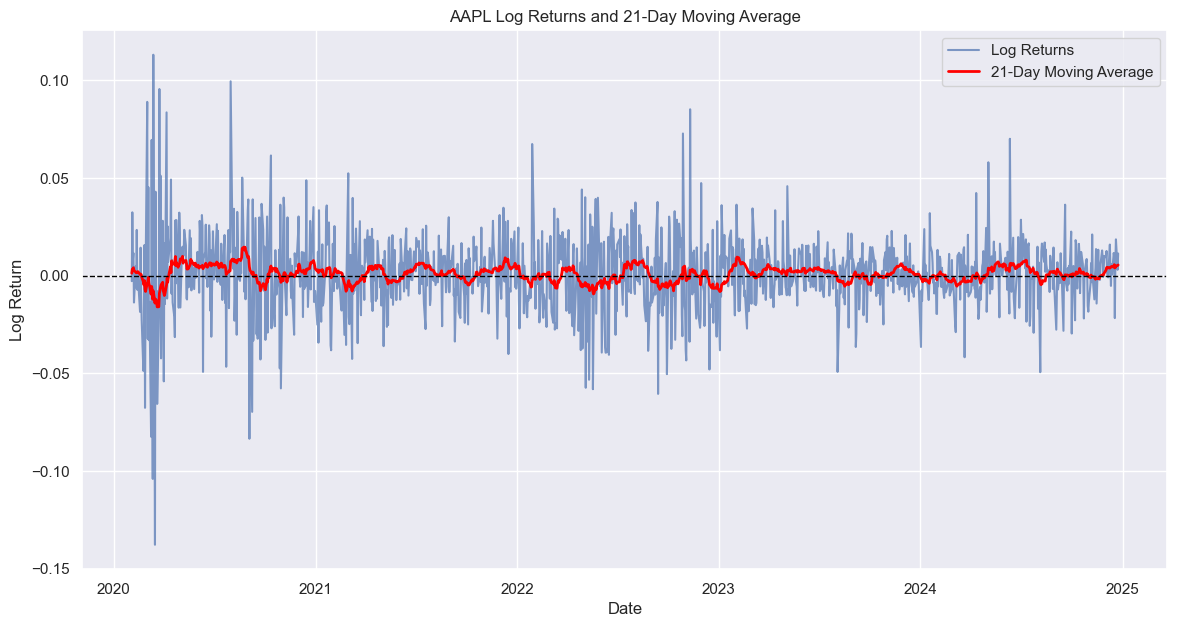

ADF Statistic (Spread): -10.400696010687971
p-value (Spread): 1.9128988369629583e-18
Critical Values (Spread): {'1%': -3.435752466943879, '5%': -2.8639256700182405, '10%': -2.5680401696175466}
The spread is stationary, indicating mean-reversion relative to the moving average.


In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Compute the moving average of log returns
window = 21  # Define the moving average window size
aapl['MA_Log_Returns'] = aapl['Log Return'].rolling(window=window).mean()

# Drop NaN values
aapl = aapl.dropna()

# Plot log returns and moving average
plt.figure(figsize=(14, 7))
plt.plot(aapl['Log Return'], label='Log Returns', alpha=0.7)
plt.plot(aapl['MA_Log_Returns'], label=f'{window}-Day Moving Average', color='red', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title(f"{ticker} Log Returns and {window}-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.savefig('log_return_moving_average.png')
plt.show()

# Analyze deviations (spread) and perform ADF test
aapl['Spread'] = aapl['Log Return'] - aapl['MA_Log_Returns']
result = adfuller(aapl['Spread'])
print("ADF Statistic (Spread):", result[0])
print("p-value (Spread):", result[1])
print("Critical Values (Spread):", result[4])

if result[1] < 0.05:
    print("The spread is stationary, indicating mean-reversion relative to the moving average.")
else:
    print("The spread is not stationary, indicating no strong evidence of mean-reversion relative to the moving average.")


## Ornstein-Uhlenbeck (OU) process

Estimated Parameters: theta = 0.009512153222070023, kappa = 0.4865622697416879, sigma = 0.19454351215711882, nu = 3.9221981117382834


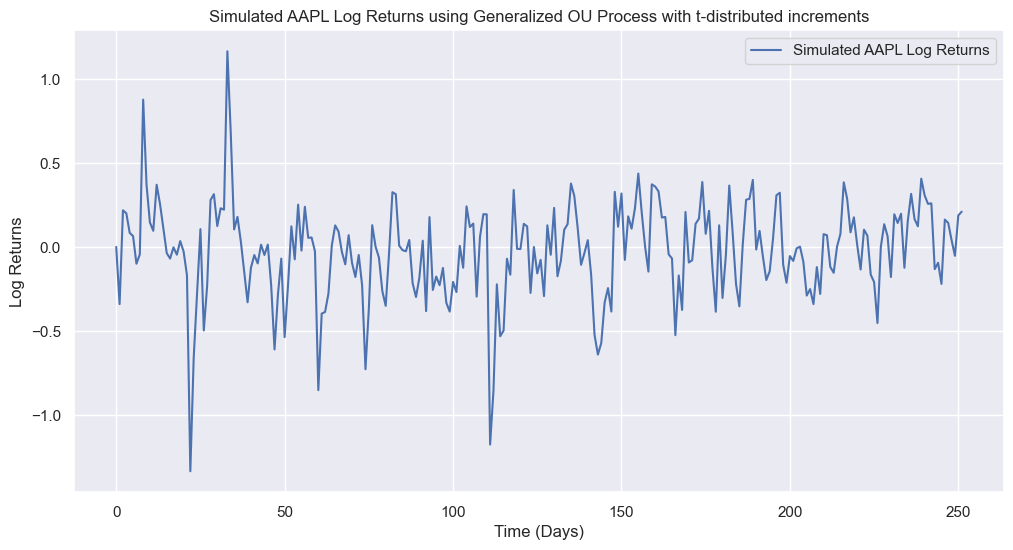

In [50]:
from scipy.optimize import minimize
from scipy.stats import t

log_returns = aapl['Log Return'].dropna().values

# Fit the Generalized OU Process with t-distributed increments
def ou_negative_log_likelihood(params, log_returns, dt):
    theta, kappa, sigma, nu = params
    n = len(log_returns)
    sum_log_likelihood = 0
    for i in range(1, n):
        residual = log_returns[i] - log_returns[i-1] * np.exp(-kappa * dt) - theta * (1 - np.exp(-kappa * dt))
        sum_log_likelihood += t.logpdf(residual, df=nu, loc=0, scale=sigma * np.sqrt(dt))
    return -sum_log_likelihood

# Initial guess for the parameters
initial_params = [0.0, 0.1, 0.2, 3.0]

# Optimize the parameters using MLE
result = minimize(ou_negative_log_likelihood, initial_params, args=(log_returns, 1), method='L-BFGS-B', bounds=((None, None), (0, None), (0, None), (2, None)))

# Extract the estimated parameters
theta_est, kappa_est, sigma_est, nu_est = result.x

print(f"Estimated Parameters: theta = {theta_est}, kappa = {kappa_est}, sigma = {sigma_est}, nu = {nu_est}")

# Simulate the Process
n_sim = 252
simulated_log_returns = np.zeros(n_sim)
for s in range(1, n_sim):
    simulated_log_returns[s] = simulated_log_returns[s-1] + kappa_est * (theta_est - simulated_log_returns[s-1]) + sigma_est * t.rvs(nu_est, size=1)

# Plot the simulated log returns
plt.figure(figsize=(12, 6))
plt.plot(simulated_log_returns, label=f'Simulated {ticker} Log Returns')
plt.title(f'Simulated {ticker} Log Returns using Generalized OU Process with t-distributed increments')
plt.xlabel('Time (Days)')
plt.ylabel('Log Returns')
plt.legend()
plt.savefig('OU process.png')
plt.show()

## Heston Model Simulation

### To estimate the correlation (ρ) between the two Wiener processes in the Heston model, you can use historical data to calculate the correlation between the stock returns and the variance (or volatility) process.

Estimated Parameters:
V0 (Initial Variance): 0.100821
mu (Drift): 0.252620
kappa (Mean Reversion Speed): 0.962314
theta (Long-Term Variance): 0.023086
xi (Vol of Vol): 0.335649
rho (Correlation): 0.002226
nu (Degrees of Freedom): 3.575906


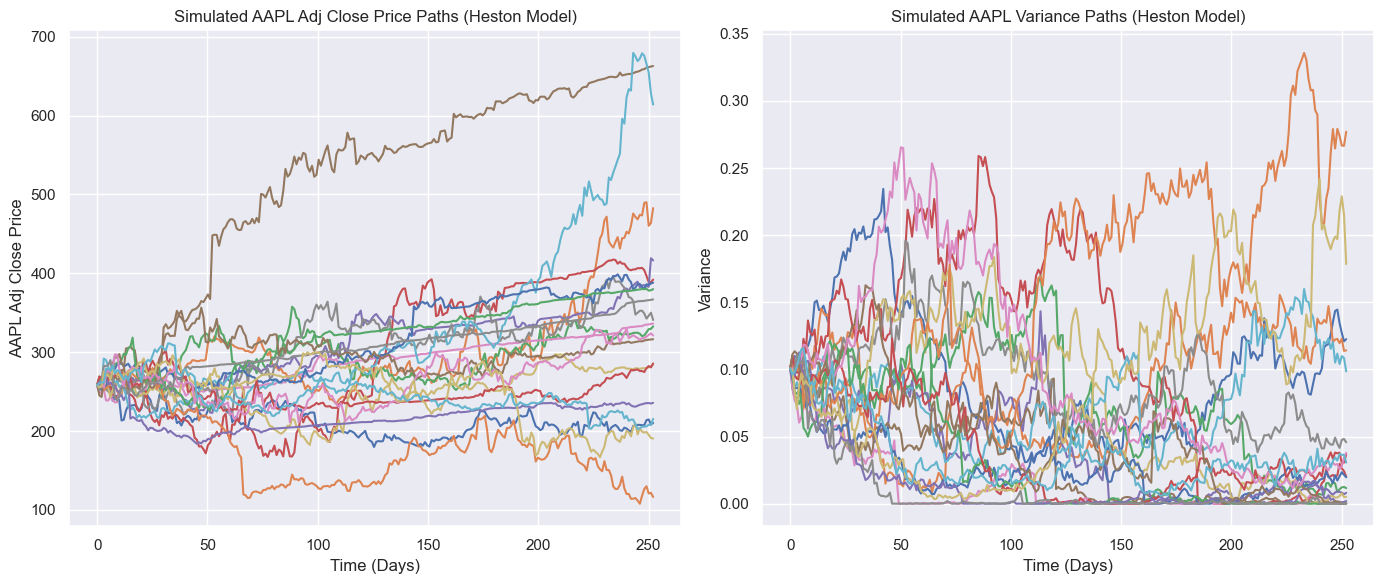

In [51]:
from scipy.optimize import minimize
from scipy.stats import t

# Fetch AAPL stock data
log_returns = aapl['Log Return'].dropna()

#=============================================================================================
# Estimated Heston Model Parameters
#=============================================================================================
trading_days_per_year = 252

# Initial V0 (Annualized)
V0 = log_returns.var() * trading_days_per_year
# Annualized drift
mu = log_returns.mean() * trading_days_per_year

# Realized variance
realized_variance = log_returns ** 2

# Define Heston variance loss function
def heston_variance_loss(params, realized_variance):
    kappa, theta, xi = params
    V = [V0]
    for i in range(1, len(realized_variance)):
        Vt = V[-1]
        delta_V = kappa * (theta - Vt) + xi * np.sqrt(max(Vt, 0)) * np.random.normal()
        V.append(Vt + delta_V)
    V = np.array(V)
    return np.sum((realized_variance.values - V) ** 2)

# Optimize kappa, theta, xi
initial_guess = [2.0, 0.02, 0.3]
result = minimize(heston_variance_loss, initial_guess, args=(realized_variance), method='Nelder-Mead', bounds=[(0, None), (0, None), (0, None)])
kappa, theta, xi = result.x

# Estimate rho
delta_variance = realized_variance.diff().dropna()
rho = np.corrcoef(log_returns[1:], delta_variance)[0, 1]

# Fit t-distribution for nu
params = t.fit(log_returns)
nu = params[0]

# Display results
print("Estimated Parameters:")
print(f"V0 (Initial Variance): {V0:.6f}")
print(f"mu (Drift): {mu:.6f}")
print(f"kappa (Mean Reversion Speed): {kappa:.6f}")
print(f"theta (Long-Term Variance): {theta:.6f}")
print(f"xi (Vol of Vol): {xi:.6f}")
print(f"rho (Correlation): {rho:.6f}")
print(f"nu (Degrees of Freedom): {nu:.6f}")

#=============================================================================================
# Heston Model Simulation
#=============================================================================================


# Parameters (use the estimated values from earlier)
T = 1.0              # Time horizon in years
dt = 1 / 252         # Daily time steps
N = int(T / dt)      # Number of steps
n_paths = 20         # Number of paths

# Heston parameters
V0 = V0                      # Initial variance 
S0 = aapl['Adj Close'][-1]   # Initial asset price
mu = mu                      # Drift 
kappa = kappa                # Speed of mean reversion
theta = theta                # Long-term variance
xi = xi                      # Volatility of variance
rho = rho                    # Correlation
nu = nu                      # Degrees of freedom for t-distribution

# Simulate paths
np.random.seed(42)
V = np.zeros((N, n_paths))
S = np.zeros((N, n_paths))
V[0, :] = V0
S[0, :] = S0

# Generate random shocks from t-distribution
for i in range(1, N):
    z1 = t.rvs(df=nu, size=n_paths)  # t-distributed random variables for returns
    z2 = t.rvs(df=nu, size=n_paths)  # t-distributed random variables for variance
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * z2  # Correlated random variables

    # Variance process
    V[i, :] = V[i - 1, :] + kappa * (theta - V[i - 1, :]) * dt + xi * np.sqrt(np.maximum(V[i - 1, :], 0)) * z2 * np.sqrt(dt)
    V[i, :] = np.maximum(V[i, :], 0)  # Ensure variance is non-negative

    # Asset price process
    S[i, :] = S[i - 1, :] * np.exp((mu - 0.5 * V[i - 1, :]) * dt + np.sqrt(V[i - 1, :]) * z1 * np.sqrt(dt))

# Plot results
time = np.linspace(0, T, N) * 252  # Convert to days

plt.figure(figsize=(14, 6))

# Asset price paths
plt.subplot(1, 2, 1)
plt.plot(time, S)
plt.title(f"Simulated {ticker} Adj Close Price Paths (Heston Model)")
plt.xlabel("Time (Days)")
plt.ylabel(f"{ticker} Adj Close Price")

# Variance paths
plt.subplot(1, 2, 2)
plt.plot(time, V)
plt.title(f"Simulated {ticker} Variance Paths (Heston Model)")
plt.xlabel("Time (Days)")
plt.ylabel("Variance")

plt.tight_layout()
plt.savefig('Heston Model Sim.png')
plt.show()



## Volatility Clustering

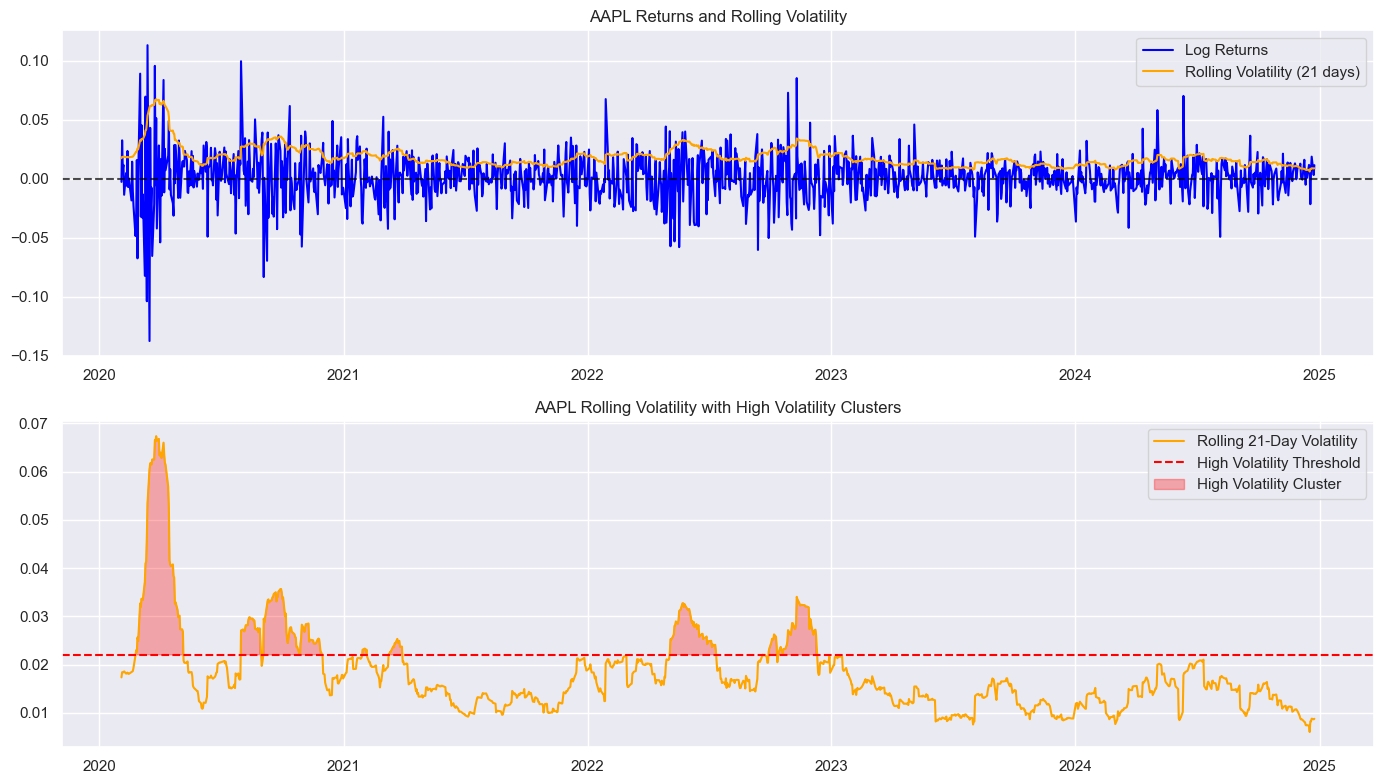

In [52]:
# Define high volatility threshold
high_vol_threshold = aapl['21-Day Rolling Volatility'].quantile(0.8)  # Top 20%
aapl['High_Vol'] = aapl['21-Day Rolling Volatility'] > high_vol_threshold

# Plot stock price and rolling volatility
plt.figure(figsize=(14, 8))

# Plot stock price
plt.subplot(2, 1, 1)
plt.plot(aapl['Log Return'].dropna(), label='Log Returns', color='blue')
plt.plot(aapl['21-Day Rolling Volatility'], label='Rolling Volatility (21 days)', color='orange')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('AAPL Returns and Rolling Volatility')
plt.legend()

# Plot rolling volatility
plt.subplot(2, 1, 2)
plt.plot(aapl['21-Day Rolling Volatility'], label='Rolling 21-Day Volatility', color='orange')
plt.axhline(high_vol_threshold, color='red', linestyle='--', label='High Volatility Threshold')
plt.fill_between(aapl.index, aapl['21-Day Rolling Volatility'], high_vol_threshold, where=aapl['High_Vol'], 
                 color='red', alpha=0.3, label='High Volatility Cluster')
plt.title('AAPL Rolling Volatility with High Volatility Clusters')
plt.legend()
plt.tight_layout()
plt.savefig('volatility_clustering.png')
plt.show()

In [53]:
# Ljung-Box Test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(aapl['Log Return']**2, lags=50)
print(lb_test)

       lb_stat      lb_pvalue
1   134.677580   3.883833e-31
2   247.982314   1.416853e-54
3   281.650951   9.302564e-61
4   348.468168   3.755929e-74
5   412.802299   5.160645e-87
6   485.773805  9.747938e-102
7   512.808532  1.412595e-106
8   575.471564  4.378283e-119
9   636.603585  2.899794e-131
10  693.462412  1.589775e-142
11  721.189169  1.545005e-147
12  737.763946  3.612111e-150
13  750.642504  5.086782e-152
14  766.695335  1.463123e-154
15  787.868582  3.325370e-158
16  814.509477  5.077591e-163
17  819.236232  3.620493e-163
18  823.803398  2.720758e-163
19  825.727437  7.283187e-163
20  835.347855  4.402795e-164
21  836.914802  1.341402e-163
22  840.803818  1.285536e-163
23  840.831515  7.939940e-163
24  851.904037  2.210730e-164
25  855.583221  2.224423e-164
26  860.255424  1.358311e-164
27  863.006461  2.076973e-164
28  863.774529  8.175614e-164
29  864.368824  3.439609e-163
30  868.698904  2.333275e-163
31  868.758549  1.231554e-162
32  869.959301  3.685332e-162
33  870.97

## GJR-GARCH Model

In [54]:
from arch import arch_model

# Define the range of values for p, o, and q
p_values = range(1, 2)  # Reduced range for p
o_values = range(0, 2)
q_values = range(1, 2)  # Reduced range for q

best_aic = float('inf')
best_order = None
best_model = None

# Perform grid search
for p in p_values:
    for o in o_values:
        for q in q_values:
            try:
                model = arch_model(aapl['Log Return'], vol='Garch', p=p, o=o, q=q, dist='StudentsT')
                model_fit = model.fit(disp='off', options={'maxiter': 1000})
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, o, q)
                    best_model = model_fit
            except Exception as e:
                print(f"Error fitting model with (p, o, q) = ({p}, {o}, {q}): {e}")
                continue

# Display the best model parameters
print(f"Best order (p, o, q): {best_order}")
print(f"Best AIC: {best_aic}")
print(best_model.summary())


# Forecast future volatility using the best model
forecasts = best_model.forecast(horizon=10)

# Display the forecasted volatility
print(forecasts.variance.iloc[-1:])


Best order (p, o, q): (1, 1, 1)
Best AIC: -6502.81815404072
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Log Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                3257.41
Distribution:      Standardized Student's t   AIC:                          -6502.82
Method:                  Maximum Likelihood   BIC:                          -6472.11
                                              No. Observations:                 1233
Date:                      Wed, Dec 25 2024   Df Residuals:                     1232
Time:                              11:24:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------

### Example interpretation:
### A higher value of α₁ means that a large squared residual in the previous period has a greater impact on the current conditional variance, indicating increased volatility clustering. 
### A higher value of β₁ indicates that a high conditional variance in the previous period leads to a higher conditional variance in the current period, further implying volatility persistence.